# Biomass Burning events at Zeppelin Station


this notebook was last run on Python 3.9.17 \
data utilised are netcdf files for the ensemble trajectories \
and fire activity data from the MODIS satellite, which are available from FIRMS under \
https://firms.modaps.eosdis.nasa.gov/download/create.php

In [290]:
#general libraries
import glob, os
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
from datetime import datetime, timedelta

#plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs

#### Define all necessary Paths and Settings

In [528]:
#Path to the trajectory data and satellite observations
file_path_BB = 'SET-PATH-TO/TRAJECTORY/DATA/'
file_path_modis = 'SET-PATH-TO/MODIS/DATA/'

#Station location
CLON, CLAT = 11.888, 78.906

#Parameters for the colormaps
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Blues
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

orig_cmap2 = plt.cm.Reds
colors2 = orig_cmap2(np.linspace(min_val, max_val, n))
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("mycmap2", colors2)

#define colous for each key in the dictionary
reg_colors = ['green', 'blue', 'red', 'orange']

#### Functions

PLEASE set the name of your trajectory files in the first function!

In [3]:
#reading the trajectory data
def read_traj(filepath, event):
    D=str(filepath)
    ncd = Dataset(D +"BB_" + str(event) + '_gdas_ZEP_500m_460h.nc') #how did you call the files?!
    lat = np.array(ncd["lat"])
    lon = np.array(ncd["lon"])
    alt = np.array(ncd["height"])
    rainfall = np.array(ncd["rainfall"])
    md = np.array(ncd['mixdepth'])
    time = np.array(ncd["time"][:, 0])
    return lon, lat, alt, rainfall,md, time


def make_traj_dataset(filepath, event):
    #Reads in a netCDF file and returns the data as a dataset
    lon,lat,alt,rainfall,md,time = read_traj(filepath, event)

    #make a dataset and create a second time variable
    output_ds = xr.Dataset()
    output_ds['starttime'] = xr.DataArray(time, dims=( 'traj'))
    output_ds['lon'] = xr.DataArray(lon, dims=('traj', 'back_time'))
    output_ds['lat'] = xr.DataArray(lat, dims=('traj', 'back_time'))
    output_ds['alt'] = xr.DataArray(alt, dims=('traj', 'back_time'))
    output_ds['md'] = xr.DataArray(md, dims=('traj', 'back_time'))
    output_ds['precip'] = xr.DataArray(rainfall, dims=('traj', 'back_time'))
    
    #make readable date format
    time_corr = []
    for tt in range(len(time[:])):
        time_corr.append(datetime(1600, 1, 1, 0, 0, 0, 0) + timedelta(time[tt]))
    output_ds['time'] = xr.DataArray(time_corr, dims=( 'traj'))
    output_ds = output_ds.assign_coords(traj=output_ds.time)
    return output_ds

def frequency_of_visit(C):
    C = np.array(C)
    mask = np.insert((np.diff(C) - 1).astype(bool), 0, True)
    visits = C[mask].size
    return visits / NUMBER_OF_TRAJECTORIES * 100

def make_monthly_df(df):
    df_monthly = pd.DataFrame(columns=['fires', 'frp_mean', 'frp_25', 'frp_75', 'confidence_mean'])
    df_monthly['fires'] = (df.groupby(df.index.month)['frp'].count())/20
    df_monthly['frp_median'] = df.groupby(df.index.month)['frp'].median()
    df_monthly['frp_25'] = df.groupby(df.index.month)['frp'].quantile(0.25)
    df_monthly['frp_75'] = df.groupby(df.index.month)['frp'].quantile(0.75)
    df_monthly['confidence_mean'] = df.groupby(df.index.month)['confidence'].mean()
    df_monthly['month'] = df_monthly.index
    return df_monthly

def make_2020_df(df):
    df_i = pd.DataFrame(columns=['fires', 'frp'])
    df_i['frp']= df['frp'].resample('M').mean()   
    df_i['fires']= df['frp'].resample('M').count()

    df_2020 = df_i['2020-01-01':'2020-12-31']
    return df_2020


#### Definition of the Biomass Burning Events

In [316]:
#select the time frame studied with in-situ observations 
df = pd.DataFrame({'start_time': ['2020-01-21 00:08:32','2020-02-21 03:44:00','2020-04-15 01:18:56',
                                    '2020-07-01 01:21:04','2020-09-16 12:45:52','2020-10-03 04:54:24','2020-11-02 10:22:56'],
                    'end_time': ['2020-01-24 19:18:24','2020-02-24 06:15:28', '2020-04-16 08:49:04',
                                    '2020-07-03 16:21:20', '2020-09-17 23:45:04','2020-10-09 23:21:36','2020-11-04 21:54:08']})

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time_diff'] = df['end_time'] - df['start_time']
df['time_diff_half'] = (df['time_diff']/2)

df['start_event'] = df['start_time'].dt.round('H') 
df['end_event'] = df['end_time'].dt.round('H')

# round to the closest hour for start_event and end_event
df['before_event'] = (df['start_time'] - df['time_diff_half']).dt.round('H')
df['after_event'] = (df['end_time'] + df['time_diff_half']).dt.round('H')
df['label'] = ['event1', 'event2', 'event3', 'event4', 'event5', 'event6', 'event7']

df

,start_time,end_time,time_diff,time_diff_half,start_event,end_event,before_event,after_event,label
0,2020-01-21 00:08:32,2020-01-24 19:18:24,3 days 19:09:52,1 days 21:34:56,2020-01-21 00:00:00,2020-01-24 19:00:00,2020-01-19 03:00:00,2020-01-26 17:00:00,event1
1,2020-02-21 03:44:00,2020-02-24 06:15:28,3 days 02:31:28,1 days 13:15:44,2020-02-21 04:00:00,2020-02-24 06:00:00,2020-02-19 14:00:00,2020-02-25 20:00:00,event2
2,2020-04-15 01:18:56,2020-04-16 08:49:04,1 days 07:30:08,0 days 15:45:04,2020-04-15 01:00:00,2020-04-16 09:00:00,2020-04-14 10:00:00,2020-04-17 01:00:00,event3
3,2020-07-01 01:21:04,2020-07-03 16:21:20,2 days 15:00:16,1 days 07:30:08,2020-07-01 01:00:00,2020-07-03 16:00:00,2020-06-29 18:00:00,2020-07-05 00:00:00,event4
4,2020-09-16 12:45:52,2020-09-17 23:45:04,1 days 10:59:12,0 days 17:29:36,2020-09-16 13:00:00,2020-09-18 00:00:00,2020-09-15 19:00:00,2020-09-18 17:00:00,event5
5,2020-10-03 04:54:24,2020-10-09 23:21:36,6 days 18:27:12,3 days 09:13:36,2020-10-03 05:00:00,2020-10-09 23:00:00,2020-09-29 20:00:00,2020-10-13 09:00:00,event6
6,2020-11-02 10:22:56,2020-11-04 21:54:08,2 days 11:31:12,1 days 05:45:36,2020-11-02 10:00:00,2020-11-04 22:00:00,2020-11-01 05:00:00,2020-11-06 04:00:00,event7


#### Reading and Cleaning data

In [ ]:
fires_mod = pd.read_csv(file_path_modis + 'fire_archive_M-C61_329620.csv') #how did you call the files?!
fires_mod['date'] = pd.to_datetime(fires_mod['acq_date'])
fires_mod = fires_mod[fires_mod['latitude'] > 30]  #remove unnecessary latitudes data
fires_mod = fires_mod[fires_mod['confidence'] >= 60] #select your confidence level

In [448]:
#create dictornaries for the trajectory data
timeinterval = 10 #depends on the length of your trajectory; chosen here are for 10 days
event_mod = {}
event_traj= {}
for i in range(7):
    event_mod[i] = fires_mod[(fires_mod['date'] >= pd.to_datetime(df['start_event'][i])- timedelta(days=timeinterval)) & (fires_mod['date'] <= pd.to_datetime(df['end_event'][i]))]
    traj_readings =  make_traj_dataset(file_path_BB, 'event'+str(i+1))
    event = traj_readings.sel(traj=slice(df['start_event'][i], df['end_event'][i]))
    event['date'] = event['time'].dt.strftime("%Y-%m-%d")
    event_traj[i] = event

#### Figures

In [470]:
#set the necessary Figure parameters
extent = 4500000 #extent of the map in meters, for 480h back trajectory you need to increase it 
len_traj= 240 #length of the trajectory in hours
bl_height = 1000 #boundary layer height in meters

HEXBIN_GRID_SIZE = 150
data_crs = ccrs.PlateCarree()
map_crs  = ccrs.LambertAzimuthalEqualArea(central_longitude=CLON, central_latitude=CLAT)
norm_frp = mpl.colors.Normalize(vmin=0, vmax=100) #normalization for the FRP values

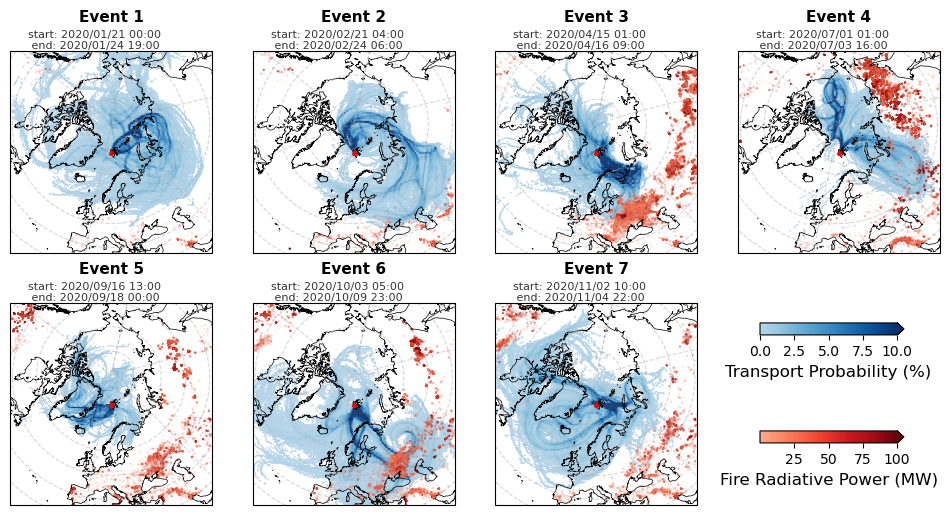

In [471]:
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': map_crs}, figsize=(12, 6))
e=0
for i in range(2):
    for j in range(4):
        axs[i,j].coastlines(resolution='50m', linewidth=0.5)
        axs[i,j].gridlines(alpha=0.5, linestyle='--')
        axs[i,j].set_extent([-extent,extent,-extent,extent], crs=map_crs)

    #event
        x2 = event_traj[e].lon[:,:len_traj].values.flatten() 
        y2 = event_traj[e].lat[:,:len_traj].values.flatten()
        C2 = np.arange(x2.size)
        NUMBER_OF_TRAJECTORIES = event_traj[e].traj.size

        imgc = axs[i,j].scatter(event_mod[e]['longitude'],event_mod[e]['latitude'], c=event_mod[e]['frp'], s=.0, transform=ccrs.PlateCarree(),cmap=cmap2, norm=norm_frp)
        
        img = axs[i,j].hexbin(x2,y2, C=C2, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=frequency_of_visit, vmin=0, vmax=10, mincnt=2, cmap=cmap)
        img1 = axs[i,j].scatter(event_mod[e]['longitude'],event_mod[e]['latitude'], c=event_mod[e]['frp'],
                                s=.2, alpha=0.1, transform=ccrs.PlateCarree(),cmap=cmap2, norm=norm_frp)
        
        
        axs[i,j].set_title("Event {}".format(e+1) , fontsize=11, pad=21, fontweight="bold")

        axs[i,j].text(0.09,1.01,"start: {} \n end: {}".format(df['start_event'][e].strftime('%Y/%m/%d %H:%M'), df['end_event'][e].strftime('%Y/%m/%d %H:%M')),
                        color='black',  transform=axs[i,j].transAxes, fontsize=8, alpha=0.8)

        axs[i,j].plot(CLON, CLAT, '^', color='red', markersize=3, transform=ccrs.PlateCarree())

        e=e+1
        if e == 7:
            break

fig.delaxes(axs[1,3])

#Transport Probability
cbar_ax = fig.add_axes([0.75, 0.4, 0.12, 0.02]) # left bottom width height
cb = fig.colorbar(img, cax=cbar_ax, orientation='horizontal',  ticks=[0.0, 2.5, 5.0, 7.5, 10.0], extend='max')
cbar_ax.set_xlabel('Transport Probability (%)', fontsize=12)

# Fire Radiative Power 
cbar_ax2 = fig.add_axes([0.75, 0.22, 0.12, 0.02]) # left bottom width height
cbar2 = fig.colorbar(imgc, cax=cbar_ax2, orientation='horizontal',  ticks=[25, 50, 75, 100], extend='max')
cbar_ax2.set_xlabel('Fire Radiative Power (MW)', fontsize=12)
cbar2.solids.set(alpha=1)

plt.savefig('BB_allevents_traj' + str(len_traj) +'.png', dpi=300, bbox_inches='tight')

##### Transport within the Boundary Layer
only shows trajectory points within the set boundary layer height

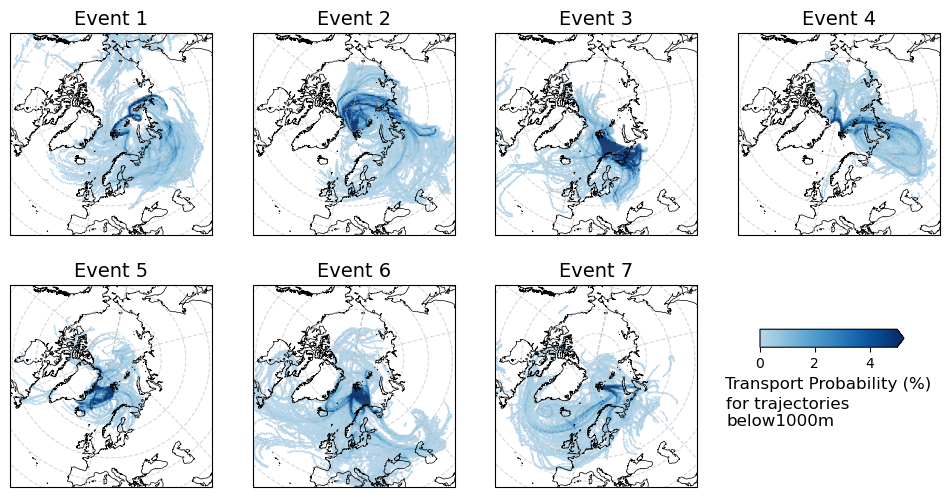

In [530]:
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': map_crs}, figsize=(12, 6))
e=0
for i in range(2):
    for j in range(4):
        axs[i,j].coastlines(resolution='50m', linewidth=0.5)
        axs[i,j].gridlines(alpha=0.5, linestyle='--')
        axs[i,j].set_extent([-extent,extent,-extent,extent], crs=map_crs)

    #event
        x2 = event_traj[e].lon[:,:len_traj].where(event_traj[e].alt[:,:len_traj] <= bl_height).values.flatten()
        y2 = event_traj[e].lat[:,:len_traj].where(event_traj[e].alt[:,:len_traj] <= bl_height).values.flatten()
        C2 = np.arange(x2.size)
        NUMBER_OF_TRAJECTORIES = event_traj[e].traj.size
        img = axs[i,j].hexbin(x2,y2, C=C2, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=frequency_of_visit, vmin=0, vmax=5, mincnt=0, cmap=cmap)

        axs[i,j].set_title("Event {}".format(e+1) , fontsize=14)

        e=e+1
        if e == 7:
            break

fig.delaxes(axs[1,3])

cbar_ax = fig.add_axes([0.75, 0.35, 0.12, 0.03]) # left bottom width height
cb = fig.colorbar(img, cax=cbar_ax, orientation='horizontal', extend='max')
cbar_ax.set_xlabel('Transport Probability (%)', fontsize=12)

plt.annotate('for trajectories \nbelow' + str(bl_height) + 'm', 
            xy=(523, 52), xycoords='figure points', fontsize=12)

plt.savefig('BB_allevents_withinBL_' + str(bl_height) +'_.png', dpi=300, bbox_inches='tight')

#### Precipitation related Figures

In [ ]:
#setting specific colors for the precipitation
#with 0 being grey to see where very little precipitation has fallen
m_blues = plt.cm.get_cmap('Blues', 256)
newcolors = m_blues(np.linspace(0.4, 1, 256))
grey = np.array([0.5, 0.5, 0.5, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

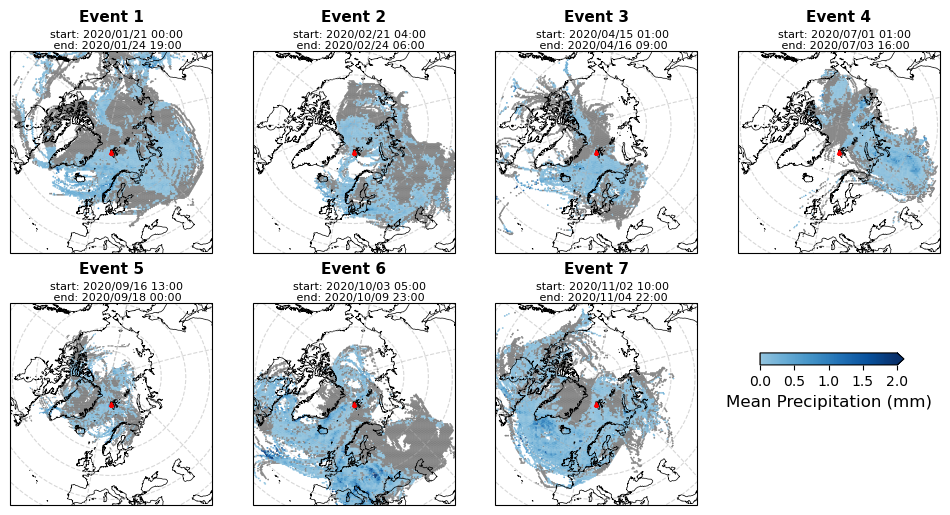

In [532]:
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': map_crs}, figsize=(12, 6))
e=0
for i in range(2):
    for j in range(4):
        axs[i,j].coastlines(resolution='50m', linewidth=0.5)
        axs[i,j].gridlines(alpha=0.5, linestyle='--')
        axs[i,j].set_extent([-extent,extent,-extent,extent], crs=map_crs)

    #event
        x2 = event_traj[e].lon[:,:len_traj].values.flatten() 
        y2 = event_traj[e].lat[:,:len_traj].values.flatten()
        C2 = event_traj[e].precip[:,:len_traj].values.flatten()
        NUMBER_OF_TRAJECTORIES = event_traj[e].traj.size
        norm = mpl.colors.Normalize(vmin=0.01, vmax=2)

        img = axs[i,j].hexbin(x2,y2, C=C2, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=compute_mean, vmin=0, vmax=2, mincnt=2, cmap=newcmp)

        axs[i,j].set_title("Event {}".format(e+1) , fontsize=11, pad=21, fontweight="bold")
        axs[i,j].text(0.2,1.01,"start: {} \n end: {}".format(df['start_event'][e].strftime('%Y/%m/%d %H:%M'), df['end_event'][e].strftime('%Y/%m/%d %H:%M')),
                        color='black',  transform=axs[i,j].transAxes, fontsize=8)        
        axs[i,j].plot(CLON, CLAT, '^', color='red', markersize=3, transform=ccrs.PlateCarree())

        e=e+1
        if e == 7:
            break

fig.delaxes(axs[1,3])

cbar_ax = fig.add_axes([0.75, 0.35, 0.12, 0.02]) # left bottom width height
cb = fig.colorbar(img, cax=cbar_ax, orientation='horizontal',  ticks=[0.0, .5, 1.0, 1.5, 2. ], extend='max')
cbar_ax.set_xlabel('Mean Precipitation (mm)', fontsize=12)

plt.savefig('BB_allevents_' + str(len_traj) +'_h_meanprecip.png', dpi=300, bbox_inches='tight')

### Longterm overview of fire activity with MODIS

Used were the MODIS C6.2 fire product downloaded from FIRMS:
https://firms.modaps.eosdis.nasa.gov/download/create.php

In [ ]:
#read in csv files in the folder MODIS-fire
all_files = glob.glob(os.path.join(file_path_modis, "*.csv")) #make list of files

dfs = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['date'] = pd.to_datetime(df['acq_date'])                         
    dfs.append(df)

# Concatenate all data into one DataFrame
modis_frame = pd.concat(dfs, ignore_index=True)

In [8]:
#make a proper timestamp for the index
modis_frame['acq_time'] = modis_frame['acq_time'].astype(str).str.zfill(4)
modis_frame['timestamp']  = pd.to_datetime(modis_frame['acq_date'] .astype(str) + ' ' + modis_frame['acq_time'] , format='%Y-%m-%d %H%M')

#set timestamp as the new index
modis_frame = modis_frame.set_index('timestamp')
modis_frame

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,date
18,39.8467,98.2798,314.4,1.1,1.1,2001-01-01,425,Terra,MODIS,75,6.03,276.5,18.7,D,2,2001-01-01
19,39.8483,98.2668,314.8,1.1,1.1,2001-01-01,425,Terra,MODIS,75,6.03,276.0,19.1,D,2,2001-01-01
152,37.9300,53.9133,307.8,1.1,1.1,2001-01-01,743,Terra,MODIS,66,6.03,288.7,9.6,D,2,2001-01-01
155,35.2487,44.4340,312.6,1.6,1.3,2001-01-01,744,Terra,MODIS,73,6.03,286.3,24.9,D,2,2001-01-01
156,34.4951,51.2794,305.5,1.0,1.0,2001-01-01,744,Terra,MODIS,62,6.03,288.8,5.5,D,0,2001-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50842413,39.1593,-122.9303,308.7,1.1,1.1,2020-12-31,2131,Aqua,MODIS,67,6.03,283.3,13.1,D,0,2020-12-31
50842415,39.7529,-122.2924,311.5,1.2,1.1,2020-12-31,2131,Aqua,MODIS,71,6.03,286.1,14.3,D,0,2020-12-31
50842416,39.7513,-122.3066,322.3,1.2,1.1,2020-12-31,2131,Aqua,MODIS,82,6.03,287.0,26.8,D,0,2020-12-31
50842417,30.3493,50.3005,305.7,2.4,1.5,2020-12-31,2201,Aqua,MODIS,65,6.03,282.7,37.3,N,2,2020-12-31


In [ ]:
#additional data can be removed based on i.e. confidence level, latitude
modis_frame = modis_frame[modis_frame['confidence'] > 60]
modis_frame = modis_frame[modis_frame['latitude'] > 30]

##### Region definition

In [28]:
#New dataframes for the different regions:
#North America:
df_NA = modis_frame[(modis_frame['longitude'] > -126) & (modis_frame['longitude'] < -71) & (modis_frame['latitude'] > 42) & (modis_frame['latitude'] < 67)]
#Black Sea:
df_BS = modis_frame[(modis_frame['longitude'] > 25) & (modis_frame['longitude'] < 48) & (modis_frame['latitude'] > 40) & (modis_frame['latitude'] < 53)]
#South Siberia:
df_SS = modis_frame[(modis_frame['longitude'] > 55) & (modis_frame['longitude'] < 130) & (modis_frame['latitude'] > 40) & (modis_frame['latitude'] < 55)]
#North Siberia:
df_NS = modis_frame[(modis_frame['longitude'] > 65) & (modis_frame['longitude'] < 150) & (modis_frame['latitude'] > 60) & (modis_frame['latitude'] < 70)]

In [437]:
#calculate the mean frp for each event_mod for each region
frp_NA, frp_BS, frp_SS, frp_NS = [],[],[],[]
for i in range(7):
    frp_NA.append(event_mod[i][(event_mod[i]['longitude'] > -126) & (event_mod[i]['longitude'] < -71) & (event_mod[i]['latitude'] > 42) & (event_mod[i]['latitude'] < 67)]['frp'].mean())
    frp_BS.append(event_mod[i][(event_mod[i]['longitude'] > 25) & (event_mod[i]['longitude'] < 48) & (event_mod[i]['latitude'] > 40) & (event_mod[i]['latitude'] < 53)]['frp'].mean())
    frp_SS.append(event_mod[i][(event_mod[i]['longitude'] > 55) & (event_mod[i]['longitude'] < 130) & (event_mod[i]['latitude'] > 40) & (event_mod[i]['latitude'] < 55)]['frp'].mean())
    frp_NS.append(event_mod[i][(event_mod[i]['longitude'] > 65) & (event_mod[i]['longitude'] < 150) & (event_mod[i]['latitude'] > 60) & (event_mod[i]['latitude'] < 70)]['frp'].mean())

#make a dataframe with the mean frp for each region and the event start date as index
frp_regions = pd.DataFrame({'North America': frp_NA, 'Black Sea': frp_BS, 'South Siberia': frp_SS, 'North Siberia': frp_NS})
frp_regions.index = df['start_event']
frp_regions

,North America,Black Sea,South Siberia,North Siberia
start_event,,,,
2020-01-21 00:00:00,47.122222,80.665000,25.560714,NaN
2020-02-21 04:00:00,49.194161,39.752991,30.114433,0.000000
2020-04-15 01:00:00,33.018710,57.919892,49.022529,55.886997
2020-07-01 01:00:00,68.072558,42.084273,78.537458,90.404644
2020-09-16 13:00:00,210.355519,46.098246,52.349133,51.559781
2020-10-03 05:00:00,70.317329,40.870678,57.110691,83.345551
2020-11-02 10:00:00,48.522187,26.744013,49.535159,49.781250


In [282]:
#make a dictionary with the 4 regions
dict = {'North America': df_NA, 'Black Sea': df_BS, 'South Siberia': df_SS, 'North Siberia': df_NS}
dict_m = {}
dict_2020= {}

#apply make_monthly_df to the dictionary
for key in dict.keys():
    df_monthly = make_monthly_df(dict[key])
    dict_m[key] = df_monthly

#monthly mean frp and fire count for 2020
for key in dict.keys():
    df_2 = make_2020_df(dict[key])
    dict_2020[key] = df_2

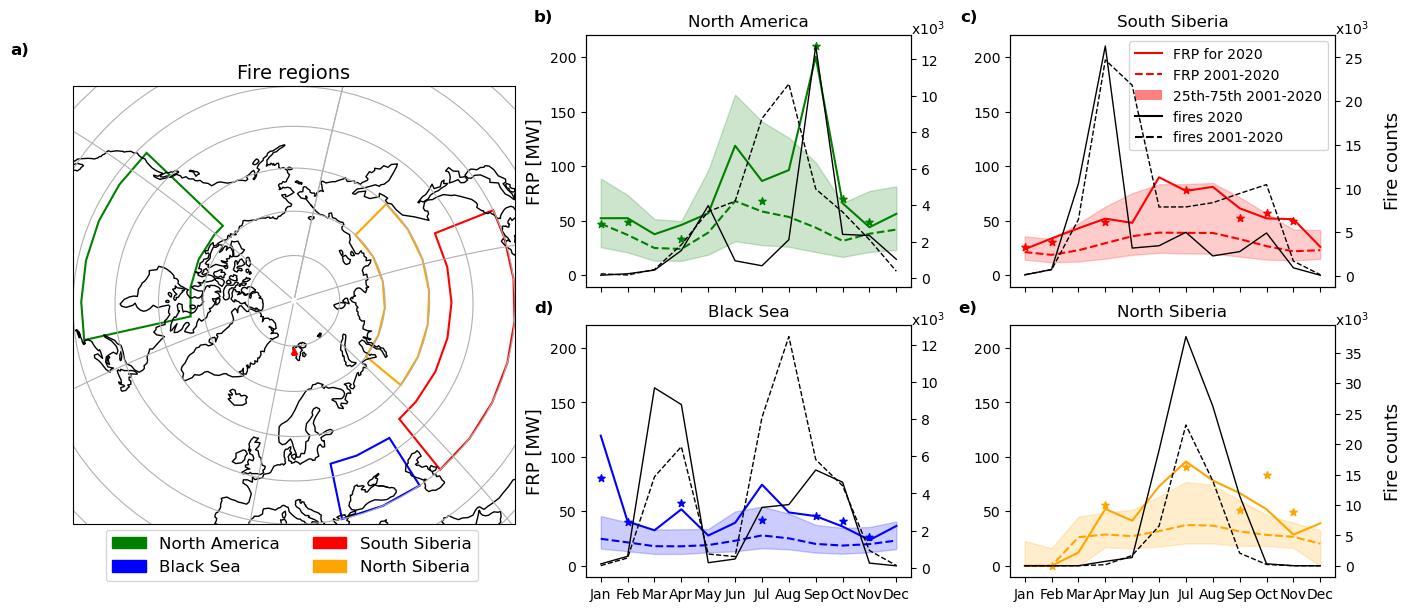

In [442]:
fig = plt.figure(figsize=(14,6), constrained_layout=True)
gs0 = fig.add_gridspec(1, 2, width_ratios=[1,2])

ax0 = fig.add_subplot(gs0[0], projection=map_crs)
ax0.coastlines()
ax0.gridlines(crs=ccrs.PlateCarree())
ax0.ylabels_bottom = False

ax0.set_extent([0, 360, 90, 40], ccrs.PlateCarree())

    #add a lat lon box for the regions
ax0.add_patch(mpl.patches.Rectangle(xy=[-126, 42], width=55, height=25, linewidth=1.5, edgecolor='green',
                               facecolor='none', transform=ccrs.PlateCarree()))
ax0.add_patch(mpl.patches.Rectangle(xy=[55, 40], width=75, height=15, linewidth=1.5, edgecolor='red',
                               facecolor='none', transform=ccrs.PlateCarree()))
ax0.add_patch(mpl.patches.Rectangle(xy=[65, 60], width=85, height=10, linewidth=1.5, edgecolor='orange',
                               facecolor='none', transform=ccrs.PlateCarree()))
ax0.add_patch(mpl.patches.Rectangle(xy=[25, 40], width=23, height=13, linewidth=1.5, edgecolor='blue',
                               facecolor='none', transform=ccrs.PlateCarree()))
ax0.plot(CLON,CLAT, '^r', markersize=5)

ax0.set_title('Fire regions', fontsize=14)
#get the legend for the regions
ax0.legend(handles=[mpl.patches.Patch(color='green', label='North America'),
                      mpl.patches.Patch(color='blue', label='Black Sea'),
                      mpl.patches.Patch(color='red', label='South Siberia'),
                      mpl.patches.Patch(color='orange', label='North Siberia')],
             loc='lower left', bbox_to_anchor=(0.055, -0.15), fancybox=True, shadow=False, ncol=2, fontsize=12)

gs01 = gs0[1].subgridspec(2, 2)

ax0_00 = fig.add_subplot(gs01[0,0])
ax0_01 = fig.add_subplot(gs01[0,1], sharey=ax0_00)
ax0_10 = fig.add_subplot(gs01[1,0], sharex=ax0_00, sharey=ax0_00)
ax0_11 = fig.add_subplot(gs01[1,1], sharex=ax0_00, sharey=ax0_00)
ax0s = np.array([[ax0_00, ax0_01], [ax0_10, ax0_11]])
ax0_01.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])

for ax in ax0s[:-1].flatten():
    ax.tick_params(axis='x', which='both', labelbottom=False)  
for ax in ax0s[1:].flatten():
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

for a in range(2):
    for b in range(2):
        key=list(dict.keys())[a+2*b]
        ax = ax0s[a, b]
        ax.set_title(key)       
        #ax.plot(dict_m[key]['month'], dict_m[key]['frp_median'],color=reg_colors[a+2*b],  label=key)
        ax.plot(dict_m[key]['month'], dict_m[key]['frp_median'],color=reg_colors[a+2*b],  label=key, linestyle='dashed')
        ax.fill_between(dict_m[key]['month'], dict_m[key]['frp_25'], dict_m[key]['frp_75'],color=reg_colors[a+2*b], alpha=0.2)

        ax.plot(dict_m[key]['month'], dict_2020[key]['frp'],color=reg_colors[a+2*b],label=key)
    
        #add in the frp for each event for each region from frp_regions
        ax.scatter(frp_regions.index.month, frp_regions[key], color=reg_colors[a+2*b], marker='*', s=30)
        
        #generate a second y axis
        ax2 = ax.twinx()
        ax2.plot(dict_m[key]['month'], dict_m[key]['fires']/1000, color='black', linestyle='dashed', linewidth=1, label='fires 2001-2020')
        ax2.plot(dict_m[key]['month'], dict_2020[key]['fires']/1000, color='black', linewidth=1, label='fires 2020')
        ax.text(1,1,'x10$^3$', color='black',  transform=ax.transAxes, fontsize=10)


ax0s[0,0].set_ylabel('FRP [MW]', fontsize=13)
ax0s[1,0].set_ylabel('FRP [MW]', fontsize=13)
ax0s[1,1].yaxis.set_label_position("right")
ax0s[1,1].set_ylabel('Fire counts',labelpad=35, fontsize=13, color='black')
ax0s[0,1].yaxis.set_label_position("right")
ax0s[0,1].set_ylabel('Fire counts',labelpad=35, fontsize=13, color='black')


legend_elements = [Line2D([0], [0], color='red', label='FRP for 2020'),
                   Line2D([0], [0], color='red', linestyle='dashed', label='FRP 2001-2020'),
                   Patch(facecolor='red', alpha=0.5, label='25th-75th 2001-2020'),
                   Line2D([0], [0], color='black', label='fires 2020'),
                   Line2D([0], [0], color='black', linestyle='dashed', label='fires 2001-2020')]

ax0s[0,1].legend(handles=legend_elements, loc='upper right') #set_ylabel('Fire counts',labelpad=35, fontsize=13, color='black')

#add a letter to each of the subplots
ax0.text(-0.1, 1.1, 'a)', transform=ax0.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax0_00.text(-0.1, 1.1, 'b)', transform=ax0_00.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax0_01.text(-0.1, 1.1, 'c)', transform=ax0_01.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax0_10.text(-0.1, 1.1, 'd)', transform=ax0_10.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax0_11.text(-0.1, 1.1, 'e)', transform=ax0_11.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.savefig('BB_regions_multiyear_events+firecount.png', dpi=300, bbox_inches='tight')


### Additional Plot for analysis

Test plot to compare the transport to the station, before, during and after events to check for changing transport path/weather pattern

In [456]:
#define times before, during and after the event
e=4 #which event are we looking at?

event_7 = make_traj_dataset(file_path_BB, 'event'+str(e+1))
event7 = event_7.sel(traj=slice(df['start_event'][e], df['end_event'][e]))
event7_b = event_7.sel(traj=slice(df['before_event'][e], df['start_event'][e]))
event7_a = event_7.sel(traj=slice(df['end_event'][e], df['after_event'][e]))

event7['date'] = event7['time'].dt.strftime("%Y-%m-%d")

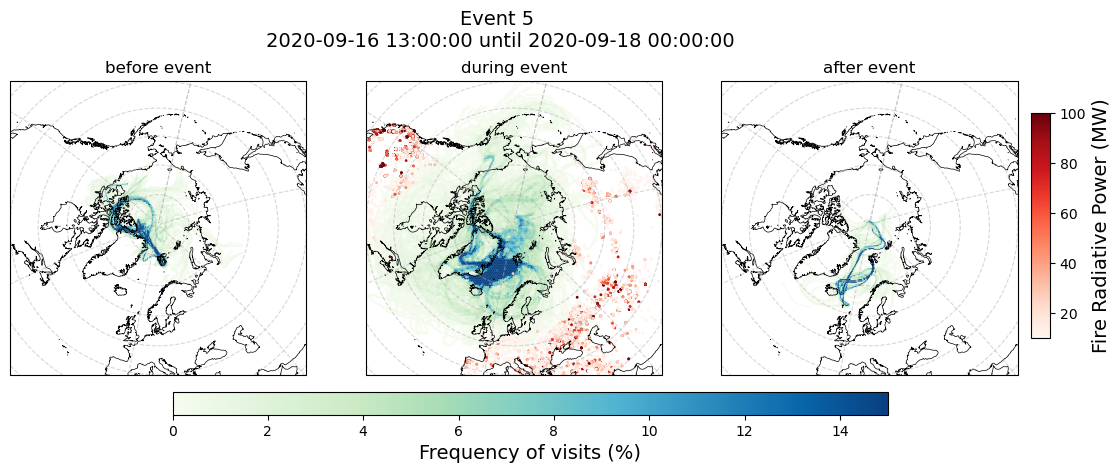

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, subplot_kw={'projection': map_crs}, figsize=(13, 4.5))
for i in [ax1,ax2,ax3]:
    i.coastlines(resolution='50m', linewidth=0.5)
    i.gridlines(alpha=0.5, linestyle='--')
    i.set_extent([0, 360, 90, 40], ccrs.PlateCarree())

#before event
x1 = event7_b.lon[:,:len_traj].values.flatten()
y1 = event7_b.lat[:,:len_traj].values.flatten()
C1 = np.arange(x1.size)
NUMBER_OF_TRAJECTORIES = event7_b.traj.size
img = ax1.hexbin(x1,y1, C=C1, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=compute_mean, vmin=0, vmax=10, mincnt=0, cmap="GnBu")

#event
x2 = event7.lon[:,:len_traj].values.flatten()
y2 = event7.lat[:,:len_traj].values.flatten()
C2 = np.arange(x2.size)
NUMBER_OF_TRAJECTORIES = event7.traj.size
img = ax2.hexbin(x2,y2, C=C2, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=frequency_of_visit, vmin=0, vmax=10, mincnt=0, cmap="GnBu")
img1 = ax2.scatter(event_mod[e]['longitude'],event_mod[e]['latitude'], c=event_mod[e]['frp'], s=1, transform=ccrs.PlateCarree(),cmap='Reds', vmin=10, vmax=100)

#after event
x3 = event7_a.lon[:,:len_traj].values.flatten()
y3 = event7_a.lat[:,:len_traj].values.flatten()
C3 = np.arange(x2.size)
NUMBER_OF_TRAJECTORIES = event7_a.traj.size
img = ax3.hexbin(x3,y3, C=C3, transform=data_crs, gridsize=HEXBIN_GRID_SIZE, linewidth=0.2,
                        reduce_C_function=frequency_of_visit, vmin=0, vmax=15, mincnt=0, cmap="GnBu")


fig.suptitle("Event {}\n {} until {}".format(e+1, df['start_event'][e], df['end_event'][e]) , fontsize=14)
ax1.set_title('before event', fontsize=12)
ax2.set_title('during event', fontsize=12)
ax3.set_title('after event', fontsize=12)

cbar_ax = fig.add_axes([0.25, 0.08, 0.55, 0.05]) # left bottom width height
cb = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')

# Specify colorbar 
cbar_ax2 = fig.add_axes([0.91, 0.25, 0.015, 0.5]) # left bottom width height
cbar2 = fig.colorbar(img1, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Fire Radiative Power (MW)', fontsize=14)

plt.savefig('BB_event'+str(e+1)+'_trajectories.png', dpi=300, bbox_inches='tight')